In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import seaborn as sns

**Data pre-processing**

In [2]:
#Code for creating data frame of testing data
data = pd.read_csv('requests.csv')
data.columns = ['timestamp', 'userID', 'sessionID', 'expiring', 'URL']

In [3]:
#Formatting the data frame so that each row represent one user. 
#All requests are saved as a string in the "URL"-column
users = list(data['userID'])
allUsers = data.set_index(['userID']).rename_axis(None)
allUsers = allUsers.drop(columns=['timestamp', 'sessionID', 'expiring'])
df = allUsers.groupby(level=0).agg(','.join)
df.reset_index(inplace=True)
df = df.rename(columns={'index': 'users'})



In [4]:
#Removing all non-letter characters from the data and assigning it to new data frame 'df_cleaned'
df_cleaned = df
request_logs = df_cleaned['URL']

cleaned_logs = []

for i in range(0, len(request_logs)):
    sequence = re.sub('[^a-zA-Z]', ' ', request_logs[i])
    sequence = sequence.lower()
    cleaned_logs.append(sequence)

df_cleaned ['request_logs'] = cleaned_logs
df_cleaned = df_cleaned.drop('URL', axis=1)

# 5 and 6: spammers, 7: data scraper
#print(cleaned_logs[7])


In [5]:
#Using the tfidf-vectorizer
tfidf_vect = TfidfVectorizer()
vect_logs = tfidf_vect.fit_transform(df_cleaned['request_logs'])

In [46]:

"""
Code for calculating variance, might delete
arr_values = []
#arr_variance = []

for i in range(0,1):
    for j in range (0, vect_logs.shape[1]):
        #print(vect_logs[i,j])
        val = vect_logs[i,j]
        arr_values.append(val)
        
print(arr_values, '\n')

array = np.array(arr_values)
print(array, '\n')
print(np.var([arr_values]))
"""

"\nCode for calculating variance, might delete\narr_values = []\n#arr_variance = []\n\nfor i in range(0,1):\n    for j in range (0, vect_logs.shape[1]):\n        #print(vect_logs[i,j])\n        val = vect_logs[i,j]\n        arr_values.append(val)\n        \nprint(arr_values, '\n')\n\narray = np.array(arr_values)\nprint(array, '\n')\nprint(np.var([arr_values]))\n"

In [6]:
#Code for checking an instance's request_logs

vector_instance=vect_logs[2] 
df_vectorized = pd.DataFrame(vector_instance.T.todense(), index=tfidf_vect.get_feature_names_out(), columns=["tfidf"])
df_vectorized.sort_values(by=["tfidf"], ascending=False)


tfidf
conversation  0.593661
profile       0.453524
page          0.348171
markasread    0.296830
chat          0.261389
send          0.261389
searchusers   0.191494
inbox         0.170523
login         0.121860
block         0.077396
report        0.044227
config        0.044181
userconfig    0.044181
like          0.041562
photos        0.041562


Some annotations for later
variance normal user[0]: 0.030732589
variance normal user[1]: 0.040072223
variance spammer 1: 0.075907392
variance spammer 2: 0.075314139
variance data scraper: 0.25440979



In [7]:
df_tfidf_scores = pd.DataFrame(vect_logs.todense(), columns= tfidf_vect.get_feature_names_out())
users = df['users']
#df_complete = pd.concat([df, df_tfidf_scores], axis=1)
#df_complete = df_complete.drop('request_logs', axis=1)
#df_complete

#Tror att vi vill hålla dem separat så att vi bara har numeriska värden att köra in i modellen. Men nu finns det en korrekt indexerad lista på alla användare:)
#print(users)
df_tfidf_scores

block      chat    config  conversation     inbox      like  \
0     0.041854  0.282709  0.023893      0.566545  0.081970  0.000000   
1     0.000000  0.257209  0.000000      0.674041  0.043025  0.023595   
2     0.077396  0.261389  0.044181      0.593661  0.170523  0.041562   
3     0.000000  0.293644  0.046531      0.551679  0.019955  0.021886   
4     0.022696  0.183961  0.000000      0.655386  0.022224  0.024376   
...        ...       ...       ...           ...       ...       ...   
999   0.022091  0.268593  0.075665      0.518321  0.032449  0.071180   
1000  0.046054  0.308113  0.030046      0.593706  0.051540  0.028264   
1001  0.023284  0.167762  0.026584      0.672384  0.068402  0.050016   
1002  0.000000  0.256528  0.000000      0.599758  0.185947  0.050987   
1003  0.098973  0.356545  0.000000      0.625197  0.096917  0.053149   

         login  markasread      page    photos   profile    report  \
0     0.131800    0.283273  0.338914  0.000000  0.471651  0.071751   
1     0.098828    0.337020  0.217422  0.023595  0.455515  0.025107   
2     0.121860    0.296830  0.348171  0.041562  0.453524  0.044227   
3     0.128341    0.275839  0.165010  0.021886  0.606243  0.093158   
4     0.122519    0.327693  0.245037  0.024376  0.511511  0.077815   
...        ...         ...       ...       ...       ...       ...   
999   0.139132    0.259160  0.258388  0.071180  0.597468  0.037871   
1000  0.088790    0.296853  0.230855  0.028264  0.516011  0.015038   
1001  0.125696    0.336192  0.272342  0.050016  0.482795  0.000000   
1002  0.106781    0.299879  0.341698  0.050987  0.470770  0.000000   
1003  0.178095    0.312598  0.267143  0.053149  0.312287  0.000000   

      searchusers      send  userconfig  
0        0.263600  0.282709    0.023893  
1        0.177891  0.257209    0.000000  
2        0.191494  0.261389    0.044181  
3        0.146676  0.293644    0.046531  
4        0.224617  0.183961    0.000000  
...           ...       ...         ...  
999      0.228574  0.268593    0.075665  
1000     0.183500  0.308113    0.030046  
1001     0.209494  0.167762    0.026584  
1002     0.170849  0.256528    0.000000  
1003     0.178095  0.356545    0.000000  

[1004 rows x 15 columns]

In [8]:
variance_columns = ['profile', 'config', 'page', 'searchusers', 'block', 'chat', 'conversation', 'inbox', 'report', 'send', 'like', 'login', 'markasread', 'photos', 'userconfig']
df_tfidf_scores['var_reqs'] = df_tfidf_scores[variance_columns].apply(lambda row: row.var(), axis=1)


In [9]:
df_tfidf_scores

block      chat    config  conversation     inbox      like  \
0     0.041854  0.282709  0.023893      0.566545  0.081970  0.000000   
1     0.000000  0.257209  0.000000      0.674041  0.043025  0.023595   
2     0.077396  0.261389  0.044181      0.593661  0.170523  0.041562   
3     0.000000  0.293644  0.046531      0.551679  0.019955  0.021886   
4     0.022696  0.183961  0.000000      0.655386  0.022224  0.024376   
...        ...       ...       ...           ...       ...       ...   
999   0.022091  0.268593  0.075665      0.518321  0.032449  0.071180   
1000  0.046054  0.308113  0.030046      0.593706  0.051540  0.028264   
1001  0.023284  0.167762  0.026584      0.672384  0.068402  0.050016   
1002  0.000000  0.256528  0.000000      0.599758  0.185947  0.050987   
1003  0.098973  0.356545  0.000000      0.625197  0.096917  0.053149   

         login  markasread      page    photos   profile    report  \
0     0.131800    0.283273  0.338914  0.000000  0.471651  0.071751   
1     0.098828    0.337020  0.217422  0.023595  0.455515  0.025107   
2     0.121860    0.296830  0.348171  0.041562  0.453524  0.044227   
3     0.128341    0.275839  0.165010  0.021886  0.606243  0.093158   
4     0.122519    0.327693  0.245037  0.024376  0.511511  0.077815   
...        ...         ...       ...       ...       ...       ...   
999   0.139132    0.259160  0.258388  0.071180  0.597468  0.037871   
1000  0.088790    0.296853  0.230855  0.028264  0.516011  0.015038   
1001  0.125696    0.336192  0.272342  0.050016  0.482795  0.000000   
1002  0.106781    0.299879  0.341698  0.050987  0.470770  0.000000   
1003  0.178095    0.312598  0.267143  0.053149  0.312287  0.000000   

      searchusers      send  userconfig  var_reqs  
0        0.263600  0.282709    0.023893  0.032354  
1        0.177891  0.257209    0.000000  0.039474  
2        0.191494  0.261389    0.044181  0.028801  
3        0.146676  0.293644    0.046531  0.036430  
4        0.224617  0.183961    0.000000  0.038587  
...           ...       ...         ...       ...  
999      0.228574  0.268593    0.075665  0.030706  
1000     0.183500  0.308113    0.030046  0.035281  
1001     0.209494  0.167762    0.026584  0.037244  
1002     0.170849  0.256528    0.000000  0.034343  
1003     0.178095  0.356545    0.000000  0.031693  

[1004 rows x 16 columns]

In [10]:
unique_reqs_columns = ['profile', 'config', 'page', 'searchusers', 'block', 'chat', 'conversation', 'inbox', 'report', 'send', 'like', 'login', 'markasread', 'photos', 'userconfig']
unique_reqs = np.count_nonzero(df_tfidf_scores[unique_reqs_columns], axis=1)
df_tfidf_scores['unique_reqs'] = unique_reqs

In [ ]:
#Code to join the df_cleaned with the tf-idf scores. Try this with Isolation forest if we need to
joined_df = pd.concat([df_cleaned, df_tfidf_scores], axis = 1)
joined_df

**Isolation Forest**

In [19]:
df_anomaly = df_tfidf_scores

#all features as anomaly inputs
#anomaly_inputs = ['profile', 'page', 'searchusers', 'block', 'chat', 'config', 'conversation', 'inbox', 'report', 'send', 'userconfig', 'like', 'login', 'markasread', 'photos', 'unique_reqs', 'var_reqs']

#selected features as anomaly inputs (most significant features fpr user 903 are removed)
anomaly_inputs = ['profile', 'page', 'searchusers', 'block', 'chat', 'conversation', 'inbox', 'report', 'send', 'like', 'login', 'markasread', 'photos', 'userconfig', 'var_reqs', 'unique_reqs']
model_if = IsolationForest(contamination=0.002, random_state=42)
model_if.fit(df_anomaly[anomaly_inputs])

c:\Users\vhage\Documents\Skolarbete\Exjobb\request-analyzer-model\.venv\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.002, random_state=42)

In [21]:
df_anomaly['anomaly_score'] = model_if.decision_function(df_anomaly[anomaly_inputs])
df_anomaly['anomaly'] = model_if.predict(df_anomaly[anomaly_inputs])

#This dataframe will only include anomaly score and anomaly label
df_anomaly_score = df_anomaly.loc[:,['anomaly_score', 'anomaly']]
df_anomaly_score.loc[df_anomaly_score['anomaly']==-1] 

#Should we add variance as a feature to use with the isolation forest?

anomaly_score  anomaly
5      -0.018380       -1
6      -0.018380       -1
7      -0.000145       -1

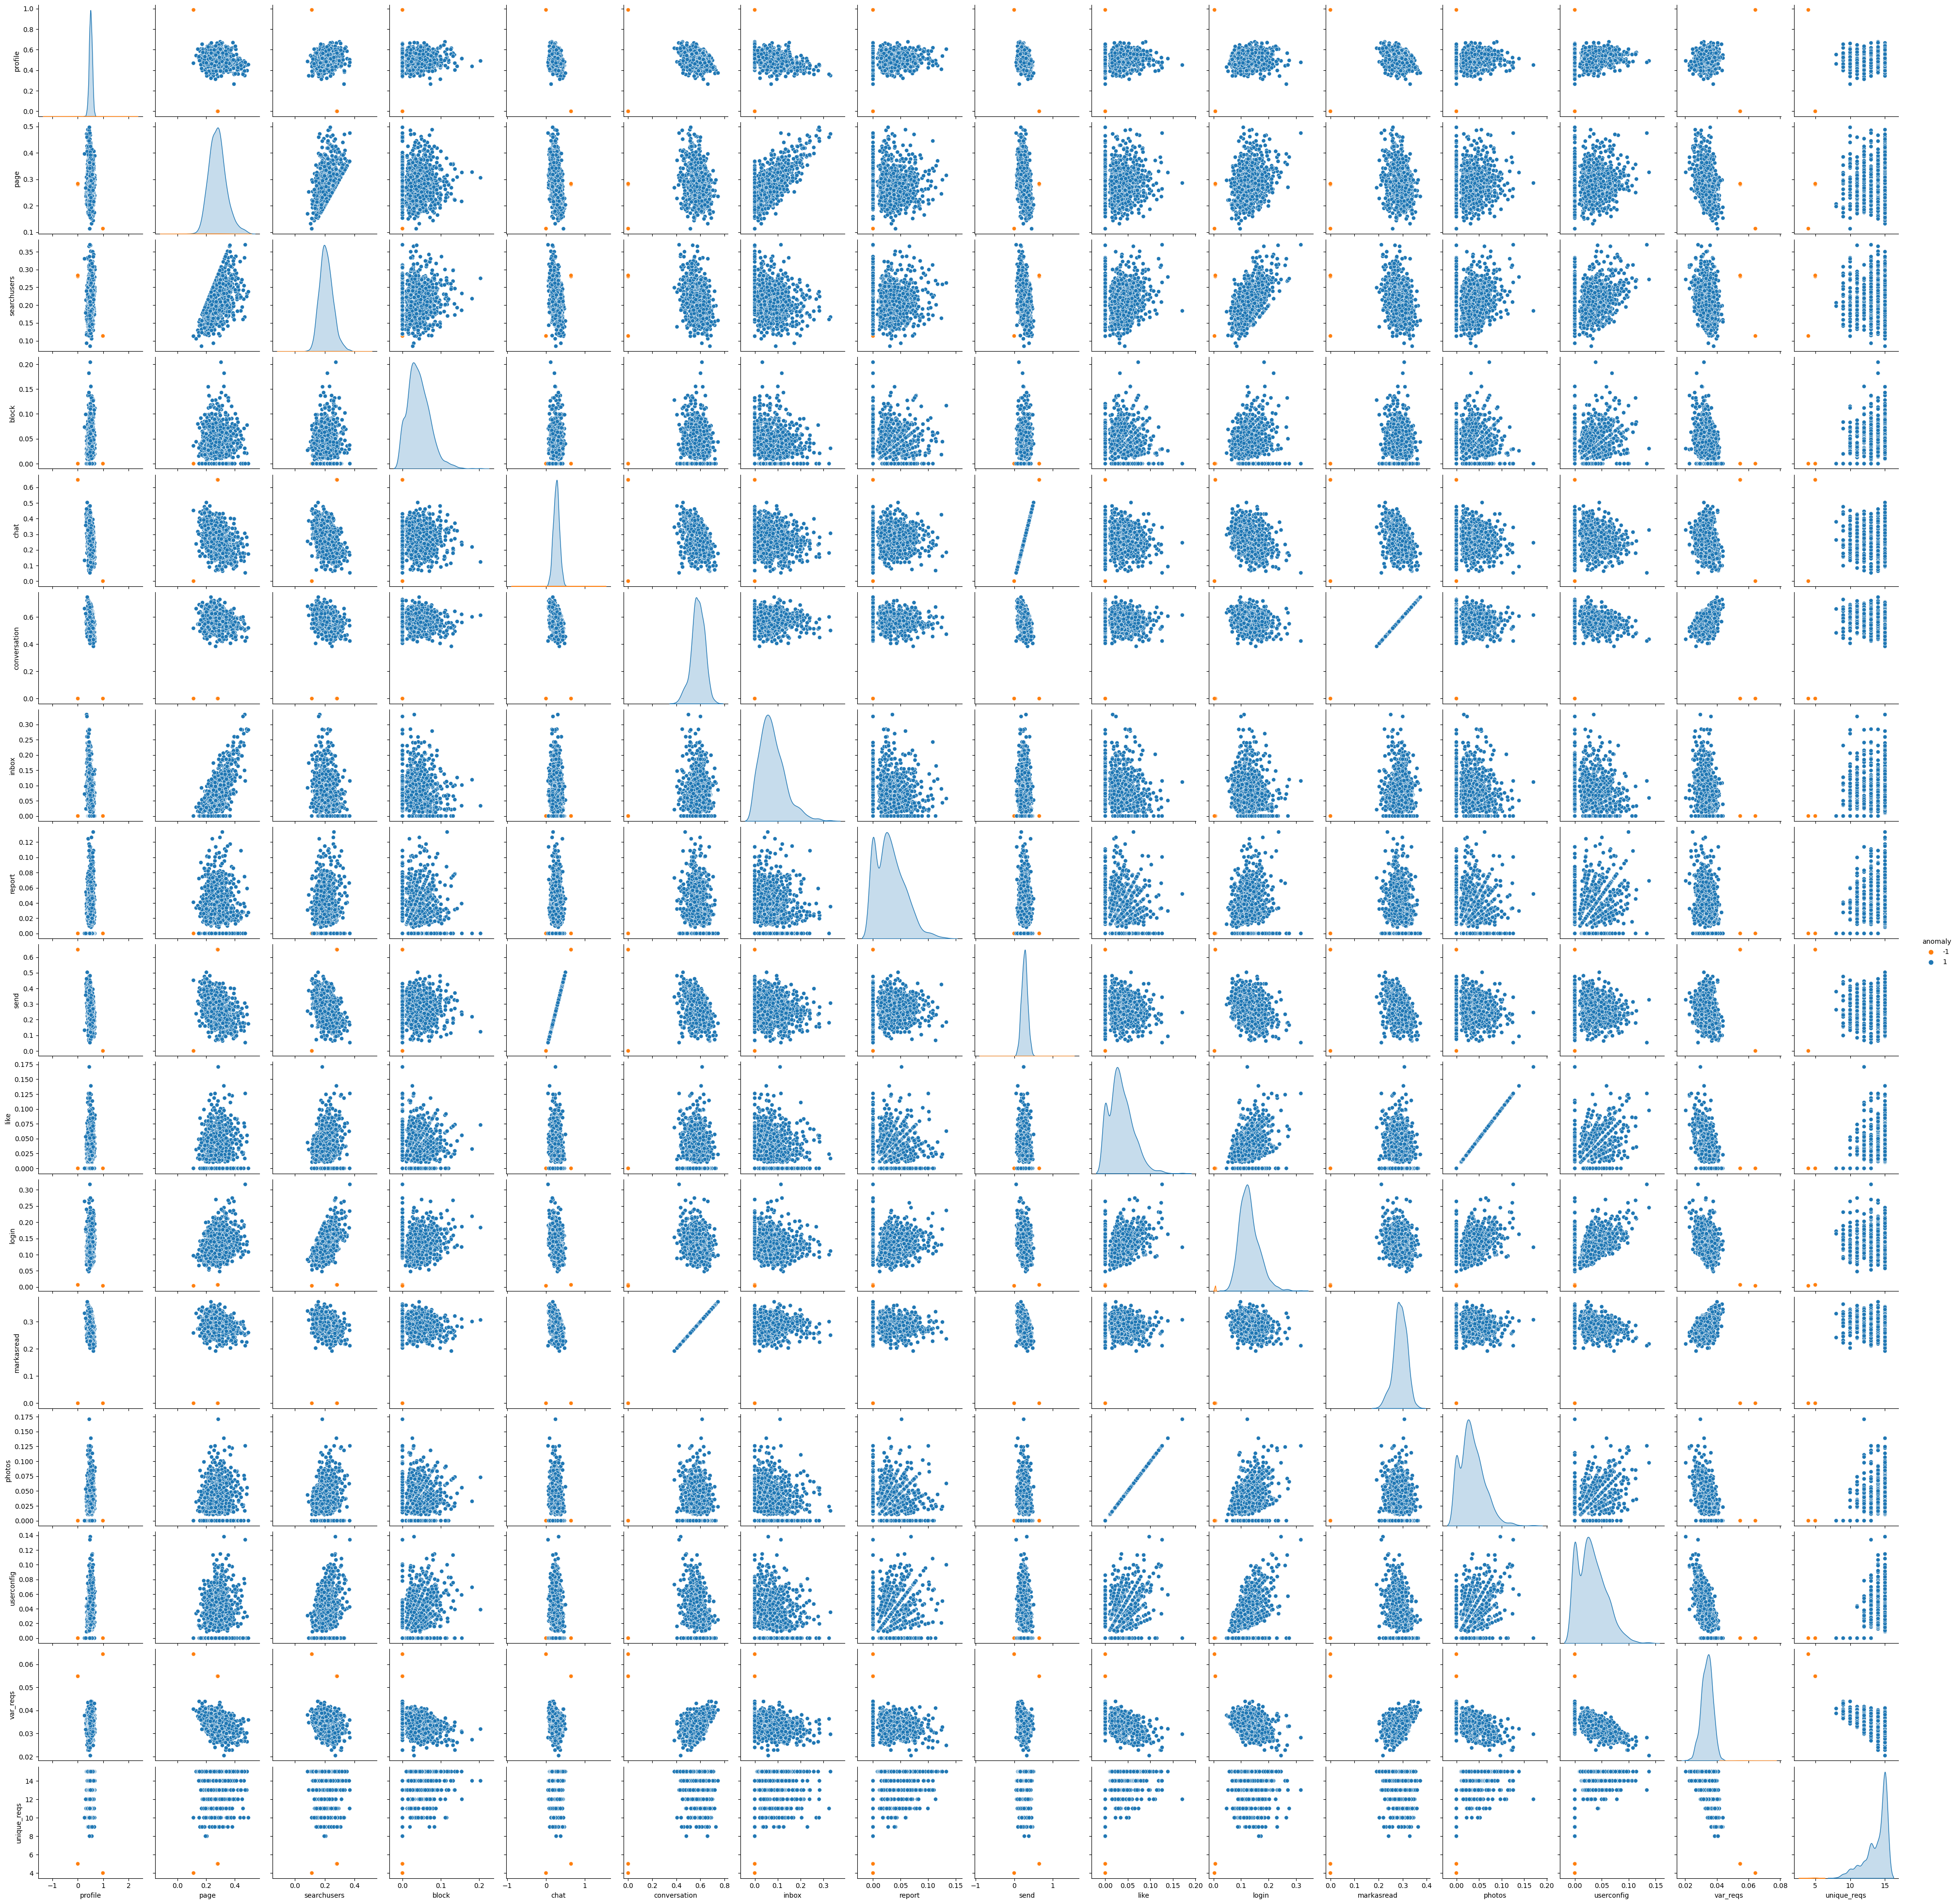

In [22]:
#Plots showcasing the outliers detected by isolation forest
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(df_tfidf_scores, vars=anomaly_inputs, hue='anomaly', palette=palette)

**Testing out TSNE**

In [39]:
#Visualizing data with t-SNE
embedded_data = TSNE(perplexity=50.0, n_iter=2000).fit_transform(np.asarray(vect_logs.todense()))
spammer1 = embedded_data[5]
spammer2 = embedded_data[6]
dataScraper = embedded_data[7]

c:\Users\rosin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\rosin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
plt.scatter(embedded_data[:,0], embedded_data[:,1])
plt.scatter(spammer1[0],spammer1[1], color='red')
plt.scatter(spammer2[0],spammer2[1], color='red')
plt.scatter(dataScraper[0],dataScraper[1], color='green')

**PCA: for dimension reduction**

In [ ]:
X = np.asarray(vect_logs.todense())
pca = PCA()
pc = pca.fit_transform(X)
pc = pd.DataFrame(pc)
print(pc.shape)
pc

(1004, 15)


0         1         2         3         4         5         6   \
0     0.014151 -0.056579  0.032928 -0.023269  0.055481 -0.034205 -0.040538   
1    -0.004119  0.024946 -0.147911 -0.022661  0.028510  0.034089 -0.014530   
2    -0.014892 -0.116458 -0.007735  0.021352 -0.046803 -0.034033  0.011968   
3     0.053916  0.163665 -0.006286  0.058890 -0.023201 -0.003443 -0.069031   
4    -0.117871  0.056486 -0.085556 -0.028776  0.044079  0.009919 -0.032389   
...        ...       ...       ...       ...       ...       ...       ...   
999  -0.003835  0.099379  0.097485  0.005731 -0.050682  0.024302 -0.019628   
1000  0.065047  0.050680 -0.043768  0.016372 -0.001074 -0.001450  0.013162   
1001 -0.146306 -0.000804 -0.094498 -0.031923 -0.004844  0.033087  0.017118   
1002 -0.020214 -0.117290 -0.037662  0.069434 -0.017167  0.054558  0.004377   
1003  0.146304 -0.115338 -0.102903 -0.108925 -0.016597 -0.007974  0.059995   

            7         8         9             10            11            12  \
0     0.025775 -0.016518  0.009518 -1.280286e-16 -3.831713e-17  1.057929e-17   
1     0.004799  0.003663 -0.007788 -8.744214e-17  7.338508e-16  1.255754e-18   
2     0.011323 -0.003120  0.009117 -1.191586e-16  4.896034e-19  2.597761e-16   
3     0.003830  0.044711  0.003305 -6.055011e-17  2.214700e-18  1.491026e-17   
4     0.033688  0.008695  0.033079  2.456695e-16 -6.957825e-18  1.102752e-18   
...        ...       ...       ...           ...           ...           ...   
999   0.004157 -0.008210 -0.023072 -1.329339e-16  4.575345e-19 -3.629689e-18   
1000  0.007790 -0.017865 -0.020936 -1.153172e-16 -8.995457e-19 -4.964431e-20   
1001 -0.003498  0.002426 -0.018177 -9.874414e-17  1.573456e-18  4.964509e-19   
1002 -0.023142 -0.014244  0.004660 -1.185357e-16 -5.354122e-19 -5.627769e-20   
1003 -0.045870  0.019982  0.047877 -1.124861e-16  1.525352e-18  6.018047e-19   

                13            14  
0    -2.338633e-18 -4.856402e-18  
1     1.164123e-18 -1.868838e-18  
2    -8.735034e-18  5.820718e-19  
3     9.567101e-17  4.410390e-17  
4     4.682014e-18 -3.520608e-18  
...            ...           ...  
999  -1.301168e-18  3.277074e-19  
1000  1.634690e-19 -6.660678e-19  
1001  1.209640e-18 -1.029603e-18  
1002 -2.431543e-18  2.037926e-18  
1003  6.097965e-19  5.041856e-19  

[1004 rows x 15 columns]

In [ ]:
print("Eigen values: ", list(np.round(pca.explained_variance_, decimals=5)))
print("PCA_variance_ratio: ", pca.explained_variance_ratio_)
print(pca.n_components)

Eigen values:  [0.01488, 0.00659, 0.0065, 0.0027, 0.00165, 0.00096, 0.00072, 0.00067, 0.00064, 0.00044, 0.0, 0.0, 0.0, 0.0, 0.0]
PCA_variance_ratio:  [4.16085399e-01 1.84349822e-01 1.81923581e-01 7.55255767e-02
 4.62256577e-02 2.67749579e-02 2.01896368e-02 1.87541698e-02
 1.79152153e-02 1.22559840e-02 3.65468573e-31 1.53534692e-32
 1.92533169e-33 4.23884406e-34 1.60565512e-34]
None


Following code just serves as a way to experiment using sequence of numbers. Could we use tfidf for vectorizing data?

In [ ]:
#Function to create a sequence of numbers. Approx. 10% of the sequences will consist of duplicates of the same number
import random

def create_sequence(arr, randVal):
    if (randVal < 1):
        val = random.randint(1,9)
        for i in range (50):
            arr.append(val)
    else:    
        for i in range (0, 50):
            arr.append(random.randint(1,9))
    return arr    

In [ ]:
#Function to give a sequence a score depending on number of consecutive duplicates
def sequence_evaluation(df):
    arr = []
    for i in range (0, df.shape[0]):
        data = df.iloc[i].to_list()
        score = 0
        lr = 0.1
        val = data[0]
        for j in range (1, len(data)):
            if (data[j] == val):
                score -= lr*data[j]
                if(lr < 1):
                    lr += 1.1*lr
            else:
                score += data[j]
                val = data[j]
        arr.append(score) 
    return arr     

In [ ]:
#Function that calculates length of the longest subsequence of consecutive duplicates for each sequence
from itertools import groupby

def longestConsecutive(df):
    arr = []
    for i in range (0, df.shape[0]):
        longest_streak = len(max([list(group) for _, group in groupby(df.iloc[i].to_list())], key=len))
        arr.append(longest_streak)
    return arr

In [ ]:
#Creation of the sequence data frame
sequence_matrix = []
for i in range (1000):
    randVal = random.randint(0,9)
    arr = []
    sequence_matrix.append(create_sequence(arr, randVal))

sequence_df = pd.DataFrame(sequence_matrix)

sequence_df['score'] = sequence_evaluation(sequence_df)
sequence_df['longestConsec'] = longestConsecutive(sequence_df.loc[:, sequence_df.columns != 'score'])
sequence_df

0  1  2  3  4  5  6  7  8  9  ...  42  43  44  45  46  47  48  49  \
0    7  3  4  4  2  9  8  9  6  5  ...   3   6   7   7   1   3   7   3   
1    2  3  9  9  1  5  5  6  9  7  ...   5   6   9   9   7   2   4   5   
2    3  8  6  1  6  3  7  4  6  6  ...   1   1   2   5   9   3   7   8   
3    4  8  3  7  6  1  4  6  6  5  ...   3   8   1   1   6   7   4   9   
4    8  9  4  8  7  3  5  7  3  8  ...   3   5   7   1   7   1   9   5   
..  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..   
995  4  4  4  4  4  4  4  4  4  4  ...   4   4   4   4   4   4   4   4   
996  5  6  4  2  6  7  2  3  8  4  ...   9   2   1   9   6   3   6   9   
997  3  3  6  4  5  5  5  4  4  1  ...   2   4   2   2   4   7   1   6   
998  8  4  6  2  8  3  6  1  4  3  ...   2   2   3   3   1   3   7   2   
999  5  5  5  5  5  5  5  5  5  5  ...   5   5   5   5   5   5   5   5   

         score  longestConsec  
0    176.76962              2  
1    122.58047              3  
2    234.89090              2  
3    184.43472              2  
4    180.12479              3  
..         ...            ...  
995 -356.77420             50  
996  230.59000              2  
997  157.45807              3  
998  153.22037              2  
999 -445.96775             50  

[1000 rows x 52 columns]

In [ ]:
#A yanky scatter plot....
plt.scatter(sequence_df['longestConsec'], sequence_df['score'])